# Chapter 5: Compressing Data via Dimensionality Reduction  
***feature extraction:*** transform or project the data onto a new feature space


## PCA

In [1]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
df_wine = pd.read_csv('http://archive.ics.uci.edu/ml/'
                     'machine-learning-databases/wine/wine.data', header=None)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [3]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[ 4.8923083   2.46635032  1.42809973  1.01233462  0.84906459  0.60181514
  0.52251546  0.08414846  0.33051429  0.29595018  0.16831254  0.21432212
  0.2399553 ]


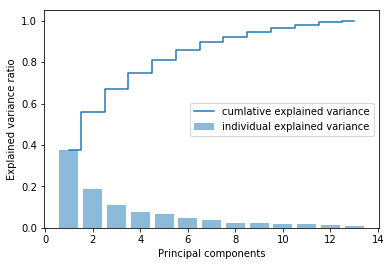

In [4]:
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1,14), var_exp, alpha=0.5, align='center',
       label='individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid',
        label='cumlative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

In [5]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i])
              for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)
# eigen_pairs

In [6]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
              eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W: \n', w)

Matrix W: 
 [[ 0.14669811  0.50417079]
 [-0.24224554  0.24216889]
 [-0.02993442  0.28698484]
 [-0.25519002 -0.06468718]
 [ 0.12079772  0.22995385]
 [ 0.38934455  0.09363991]
 [ 0.42326486  0.01088622]
 [-0.30634956  0.01870216]
 [ 0.30572219  0.03040352]
 [-0.09869191  0.54527081]
 [ 0.30032535 -0.27924322]
 [ 0.36821154 -0.174365  ]
 [ 0.29259713  0.36315461]]


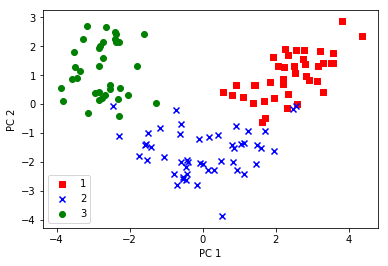

In [7]:
X_train_pca = X_train_std.dot(w)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],
                X_train_pca[y_train==l, 1],
                c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

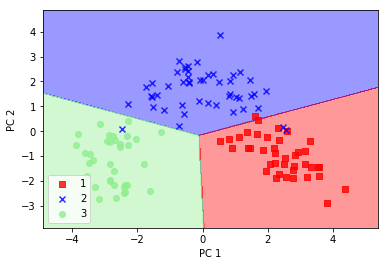

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from plot_decision_regions import plot_decision_regions
pca = PCA(n_components=2)
lr = LogisticRegression()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()


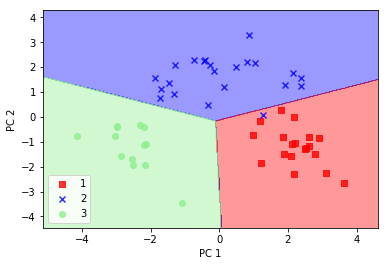

In [9]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()


## Linear discriminant analysis (LDA)

In [10]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label-1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



In [11]:
d = 13
S_w = np.zeros((d,d))
for label,mv in zip(range(1,4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_w += class_scatter
print('Within-class scatter matrix: %sx%s' % (S_w.shape[0], S_w.shape[1]))

Within-class scatter matrix: 13x13


In [12]:
print('Class label distribution: %s'
     % np.bincount(y_train)[1:])

Class label distribution: [40 49 35]


In [13]:
mean_overall = np.mean(X_train_std, axis=0)
S_B = np.zeros((d, d))
for i,mean_vec in enumerate(mean_vecs):
    n = X[y==i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

In [14]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_w).dot(S_B))
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i])
              for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

643.015384346
225.086981854
7.07080191794e-14
5.50670620214e-14
4.43857629526e-14
3.7079475303e-14
2.87521248092e-14
2.87521248092e-14
2.14439925634e-14
2.14439925634e-14
1.92096127065e-14
1.50838372013e-14
7.96695581911e-15


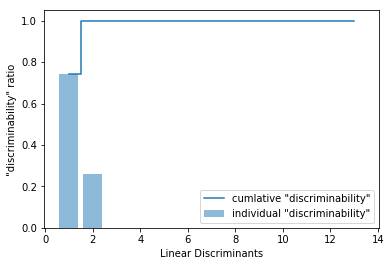

In [15]:
tot = sum(eigen_vals.real)
discr = [(i/tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1,14), discr, alpha=0.5, align='center',
       label='individual "discriminability"')
plt.step(range(1,14), cum_discr, where='mid',
        label='cumlative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.legend(loc='best')
plt.show()

In [16]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W: \n', w)

Matrix W: 
 [[-0.0707  0.3778]
 [ 0.0359  0.2223]
 [-0.0263  0.3813]
 [ 0.1875 -0.2955]
 [-0.0033 -0.0143]
 [ 0.2328 -0.0151]
 [-0.7719 -0.2149]
 [-0.0803 -0.0726]
 [ 0.0896 -0.1767]
 [ 0.1815  0.2909]
 [-0.0631 -0.2376]
 [-0.3794 -0.0867]
 [-0.3355  0.586 ]]


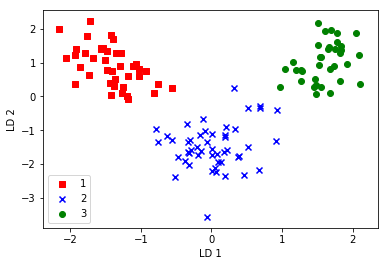

In [17]:
X_train_lda = X_train_std.dot(w)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0],
                X_train_lda[y_train==l, 1],
                c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

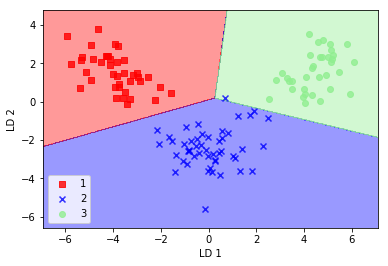

In [19]:
lr = LogisticRegression()
lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

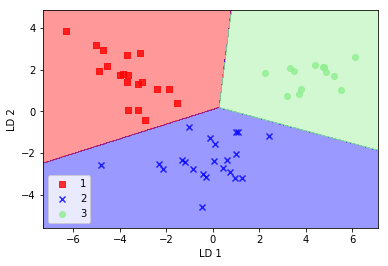

In [20]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()


## Kernel PCA

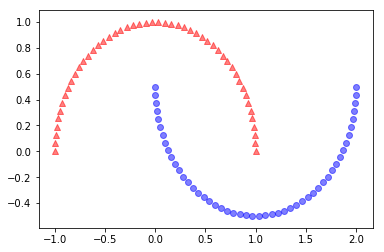

In [24]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.show()

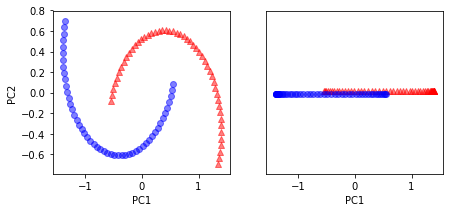

In [25]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1],
             color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1],
             color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y==0, 0], np.zeros((50,1))+0.02,
             color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((50,1))-0.02,
             color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

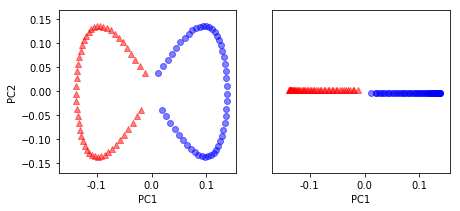

In [26]:
from matplotlib.ticker import FormatStrFormatter
from kernelPCA import rbf_kernel_pca
X_kpca,_ = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],
             color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
             color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02,
             color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02,
             color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
plt.show()

In [75]:
# print(X_kpca)

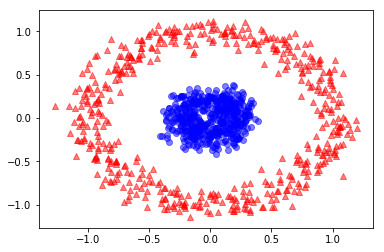

In [27]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000, random_state=123,
                   noise=0.1, factor=0.2)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.show()

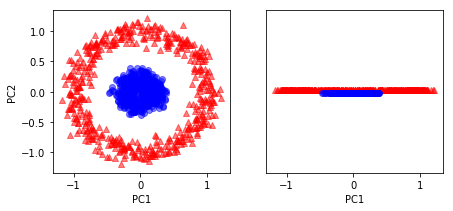

In [28]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1],
             color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1],
             color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y==0, 0], np.zeros((500,1))+0.02,
             color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((500,1))-0.02,
             color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

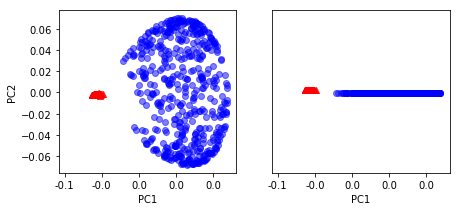

In [29]:
X_kpca,_ = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],
             color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
             color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((500,1))+0.02,
             color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((500,1))-0.02,
             color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
plt.show()

In [49]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)
print(lambdas)

[7.062724756679958]


In [50]:
X_new = X[25]
print(X_new)
X_proj = alphas[25]
print(X_proj)

# the projection is not accurate
# it is not equal to the kernelPCA in sklearn
# it does not normalize the eigenvecs
# the above is the scatter of PC direction
# not the principal component
# Ka = lambda a
# thus Ka/lambda = a
def project_x(X_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((X_new-row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    # normalize the eigenvector by its eigenvalues
    return k.dot(alphas / lambdas)
X_reproj = project_x(X_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
print(X_reproj)
# print(sum(alphas^2))

[ 1.8713  0.0093]
[ 0.0788]
[ 0.0788]


[ 1.8713  0.0093]
[ 0.0788]
[ 0.0788]


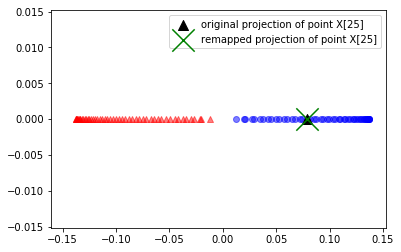

In [51]:
X_new = X[25]
print(X_new)
X_proj = alphas[25]
print(X_proj)
X_reproj = project_x(X_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
print(X_reproj)
plt.scatter(alphas[y==0, 0], np.zeros((50)), color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y==1, 0], np.zeros((50)), color='blue', marker='o', alpha=0.5)
plt.scatter(X_proj, 0, color='black', label='original projection of point X[25]',
           marker='^', s=100)
plt.scatter(X_reproj, 0, color='green', label='remapped projection of point X[25]',
           marker='x', s=500)
plt.legend(scatterpoints=1)
plt.show()

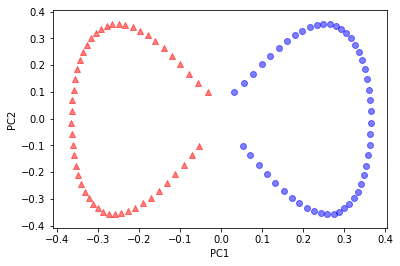

In [52]:
# the actual a is eigenvec/sqrt(eigenval)
# thus the projection is normalized to sqrt(eignval)
# the final scatter plot is the same as the kernelPCA
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=2)

def project_x1(X_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((X_new-row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    # normalize the eigenvector by its eigenvalues
    return k.dot(alphas / np.sqrt(lambdas))
X_reproj = np.zeros((X.shape[0],2))
for i in range(X.shape[0]):
    X_reproj[i] = project_x1(X[i], X, gamma=15, alphas=alphas, lambdas=lambdas)
plt.scatter(X_reproj[y==0, 0], X_reproj[y==0, 1],
           color='red', marker='^', alpha=0.5)
plt.scatter(X_reproj[y==1, 0], X_reproj[y==1, 1],
           color='blue', marker='o', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [53]:
from sklearn.decomposition import KernelPCA
X, y =make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca  = scikit_kpca.fit_transform(X)

In [56]:
print(X_skernpca[25])
print(X_reproj[25])

[ 0.2093 -0.3348]
[ 0.2093 -0.3346]


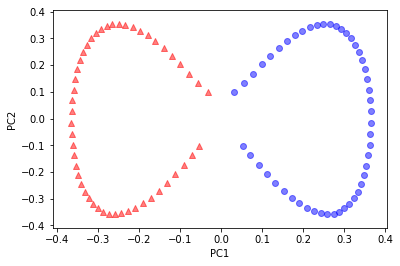

In [57]:
plt.scatter(X_skernpca[y==0, 0], X_skernpca[y==0, 1],
           color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1],
           color='blue', marker='o', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Summary
1. PCA
2. LDA
3. kernel PCA

The projection of X in kernel PCA is actually normalized eigenvector!
Deduce the results!